In [41]:
import torch
import torch.nn
import torch.optim
import torch.utils.data
import torch.nn.functional as F
from splitcross import SplitCrossEntropyLoss

import numpy as np
import networkx as nx
import math
import json
import time

import data
import os
from utils import batchify
from argparse import Namespace
from model import AWDRNNModel
from train import train, evaluate
import datetime

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ptb_stats = []
for fn in os.listdir('train_logs_single_run'):
    if fn.endswith('.json'):
        ptb_stats.append(json.load(open(os.path.join('train_logs_single_run', fn), 'r')))

In [8]:
ptb_final_test_ppl = np.array([x['test_losses'][-1] if len(x['test_losses']) > 0 and not np.isnan(x['test_losses'][-1]) else np.inf for x in ptb_stats])

In [5]:
hywiki_stats = []
for fn in os.listdir('tmp/hywiki_logs/'):
    if fn.endswith('.json'):
        hywiki_stats.append(json.load(open(os.path.join('tmp/hywiki_logs/', fn), 'r')))

In [14]:
hywiki_stats = sorted(hywiki_stats, key=lambda x: x['recepie_id'])

In [15]:
hywiki_final_test_ppl = np.array([x['test_losses'][-1] if len(x['test_losses']) > 0 and not np.isnan(x['test_losses'][-1]) else np.inf for x in hywiki_stats])

In [26]:
hywiki_final_test_ppl

array([  3.58153327,   3.63988121,   3.66681627, 328.25798373,
         3.84075944,   3.78854312,          inf,   3.79394799,
         3.84597068,   3.82153153,   3.71622498,          inf,
         4.0374107 ,   3.74345235,   5.08052627,   3.81947005,
         3.81764669,   3.79271558,   3.81662899,   3.79745759,
         3.79137214,   3.80704864,   3.89652049,          inf,
         3.89941072,   5.0007672 ,   3.83676524,          inf,
         3.87751732,   3.92219339,          inf,   3.98729599,
         3.86660992,   3.85565838,   3.82383047,   3.93804714,
         3.82671969,   3.70756401,          inf,          inf,
         4.051211  ,   3.85569249,   3.88515157,          inf,
                inf,          inf,          inf,   3.9044146 ,
                inf,   3.84932109])

In [18]:
top_ptb_final_test_ppl = ptb_final_test_ppl[np.argsort(ptb_final_test_ppl)[:len(hywiki_stats)]]

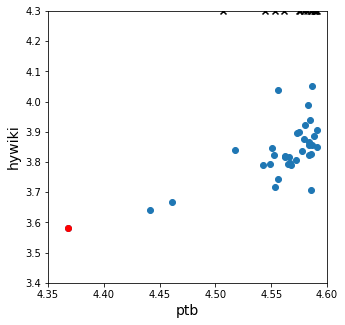

In [63]:
plt.figure(figsize=(5, 5))
plt.scatter(top_ptb_final_test_ppl, hywiki_final_test_ppl)
plt.scatter([top_ptb_final_test_ppl[0]], [hywiki_final_test_ppl[0]], color='red')
sub_inds = np.where(hywiki_final_test_ppl > 4.3)[0]
plt.scatter(top_ptb_final_test_ppl[sub_inds], [4.3]*len(sub_inds), color='k', marker='x')
plt.xlim([4.35, 4.6])
plt.ylim([3.4, 4.3])
len(sub_inds)
plt.xlabel('ptb', fontsize=14)
plt.ylabel('hywiki', fontsize=14)
plt.savefig('data/figures/ptb_vs_hywiki.png', dpi=300, bbox_inches='tight')

In [43]:
kkwiki_stats = []
for fn in os.listdir('tmp/kkwiki_logs/'):
    if fn.endswith('.json'):
        kkwiki_stats.append(json.load(open(os.path.join('tmp/kkwiki_logs/', fn), 'r')))

In [44]:
kkwiki_stats = sorted(kkwiki_stats, key=lambda x: x['recepie_id'])

In [45]:
kkwiki_final_test_ppl = np.array([x['test_losses'][-1] if len(x['test_losses']) > 0 and not np.isnan(x['test_losses'][-1]) else np.inf for x in kkwiki_stats])

In [46]:
kkwiki_final_test_ppl

array([  2.95665407,   3.01600802,   3.04915246, 233.62200599,
         3.22237452,   3.13802612,          inf,   3.17225197,
         3.21571422,   3.14932906,   3.09725798,          inf,
         3.28911221,   3.1189393 ,   4.96721081,   3.22610784,
         3.20583686,   3.16551064,   3.19365385,   3.17038154,
         3.18287198,   3.16336851,   3.30661264,          inf,
         3.2745826 ,   4.93869042,   3.20279669,          inf,
         3.24551587,   3.25996716,          inf,   3.33332233,
         3.25180505,   3.21772269,   3.18234109,   3.31421734,
         3.18746178,   3.09322663,          inf,          inf,
         3.46104902,   3.24818325,   3.26825061,          inf,
         3.34067454,          inf,          inf,   3.25722627,
                inf,   3.24361809])

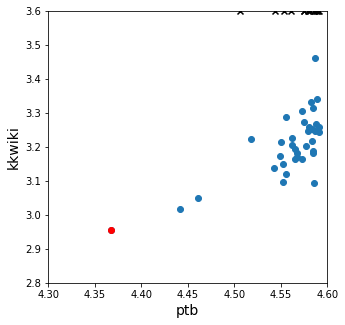

In [64]:
plt.figure(figsize=(5, 5))
plt.scatter(top_ptb_final_test_ppl, kkwiki_final_test_ppl)
plt.scatter([top_ptb_final_test_ppl[0]], [kkwiki_final_test_ppl[0]], color='red')
sub_inds = np.where(kkwiki_final_test_ppl > 3.6)[0]
plt.scatter(top_ptb_final_test_ppl[sub_inds], [3.6]*len(sub_inds), color='k', marker='x')
plt.xlim([4.3, 4.6])
plt.ylim([2.8, 3.6])
len(sub_inds)
plt.xlabel('ptb', fontsize=14)
plt.ylabel('kkwiki', fontsize=14)
plt.savefig('data/figures/ptb_vs_kkwiki.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'kkwiki perplexity')

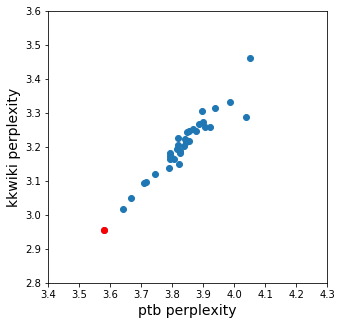

In [59]:
plt.figure(figsize=(5, 5))
plt.scatter(hywiki_final_test_ppl, kkwiki_final_test_ppl)
plt.scatter([hywiki_final_test_ppl[0]], [kkwiki_final_test_ppl[0]], color='red')
sub_inds = np.where(kkwiki_final_test_ppl > 3.6)[0]
plt.scatter(top_ptb_final_test_ppl[sub_inds], [3.6]*len(sub_inds), color='k', marker='x')
plt.xlim([3.4, 4.3])
plt.ylim([2.8, 3.6])
len(sub_inds)
plt.xlabel('ptb perplexity', fontsize=14)
plt.ylabel('kkwiki perplexity', fontsize=14)